In [1]:
import os
import numpy as np
import pandas as pd
os.chdir("../../../")

In [2]:
import scnet as sn
import scanpy as sc

Using TensorFlow backend.
/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mohsen/miniconda3

In [3]:
sc.settings.set_figure_params(dpi=200)

In [4]:
condition_key = "study"
cell_type_key = "cell_type"

In [5]:
adata = sc.read("./data/pancreas/pancreas_normalized.h5ad")
adata

AnnData object with n_obs × n_vars = 15681 × 1000 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [6]:
target_batches = ['Pancreas inDrop', 'Pancreas SS2']

In [7]:
adata.obs[condition_key].value_counts()

Pancreas inDrop         8391
Pancreas SS2            2961
Pancreas CelSeq2        2426
Pancreas CelSeq         1271
Pancreas Fluidigm C1     632
Name: study, dtype: int64

In [8]:
adata_for_training = adata[~adata.obs[condition_key].isin(target_batches)]
adata_out_of_sample = adata[adata.obs[condition_key].isin(target_batches)]

In [9]:
train_adata, valid_adata = sn.tl.train_test_split(adata_for_training, 0.80)
train_adata.shape, valid_adata.shape

((3463, 1000), (866, 1000))

In [11]:
n_conditions = len(train_adata.obs[condition_key].unique().tolist())
n_conditions

3

In [15]:
network = sn.archs.CVAE(x_dimension=train_adata.shape[1], 
                             z_dimension=10,
                             architecture=[128, 64, 32],
                             n_conditions=n_conditions,
                             lr=0.001,
                             alpha=0.00005,
                             beta=100.0,
                             eta=1.0,
                             clip_value=1000.0,
                             use_batchnorm=True,
                             loss_fn='nb',
                             model_path="./models/CVAE/test/",
                             dropout_rate=0.2,
                             )

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/home/mohsen/scnet/surgeon/models/_cvae.py:159: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  output=h_disp)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 2000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 2)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 2002)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
first_layer (Dense)             (None, 128)          256256      concatenate_1[0][0]              
__________

In [16]:
conditions = adata.obs[condition_key].unique().tolist()
condition_encoder = sn.utils.create_dictionary(conditions, [])
condition_encoder

{'Pancreas inDrop': 0, 'Pancreas Celseq': 1}

In [17]:
network.train(train_adata,
              valid_adata, 
              condition_key=condition_key,
              le=condition_encoder, 
              n_epochs=10000,
              batch_size=128, 
              early_stop_limit=200,
              lr_reducer=150, 
              n_per_epoch=0,
              save=False, 
              retrain=True,
              verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 7876 samples, validate on 1969 samples
Epoch 1/10000
 - 2s - loss: 0.9517 - nb: 0.9510 - val_loss: 0.9527 - val_nb: 0.9519
Epoch 2/10000
 - 0s - loss: 0.9372 - nb: 0.9364 - val_loss: 0.9395 - val_nb: 0.9387
Epoch 3/10000
 - 0s - loss: 0.9241 - nb: 0.9234 - val_loss: 0.9276 - val_nb: 0.9268
Epoch 4/10000
 - 0s - loss: 0.9122 - nb: 0.9115 - val_loss: 0.9161 - val_nb: 0.9153
Epoch 5/10000
 - 0s - loss: 0.9011 - nb: 0.9003 - val_loss: 0.9049 - val_nb: 0.9041
Epoch 6/10000
 - 0s - loss: 0.8901 - nb: 0.8894 - val_loss: 0.8935 - val_nb: 0.8928
Epoch 7/10000
 - 0s - loss: 0.8794 - nb: 0.8787 - val_loss: 0.8824 - val_nb: 0.8816
Epoch 8/10000
 - 0s - loss: 0.8687 - nb: 0.8679 - val_loss: 0.8715 - val_nb: 0.8707
Epoch 9/10000
 - 0s - loss: 0.8583 - nb: 0.8576 - val_loss: 0.8602 - val_nb: 0.8595
Epoch 10/10000
 - 0s - loss: 0.8477 - nb: 0.8470 - val_loss: 0.8491 - val_nb: 0.8484
Epoch 11/10000
 - 0s - loss: 0.8370 - nb: 0.8363 - val_loss: 0.

In [18]:
encoder_labels, _ = sn.utils.label_encoder(
    adata, label_encoder=network.condition_encoder, condition_key=condition_key)

In [19]:
latent_adata = network.to_latent(adata, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 9845 × 20 
    obs: 'batch', 'study', 'cell_type', 'n_counts', 'size_factors'

In [20]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

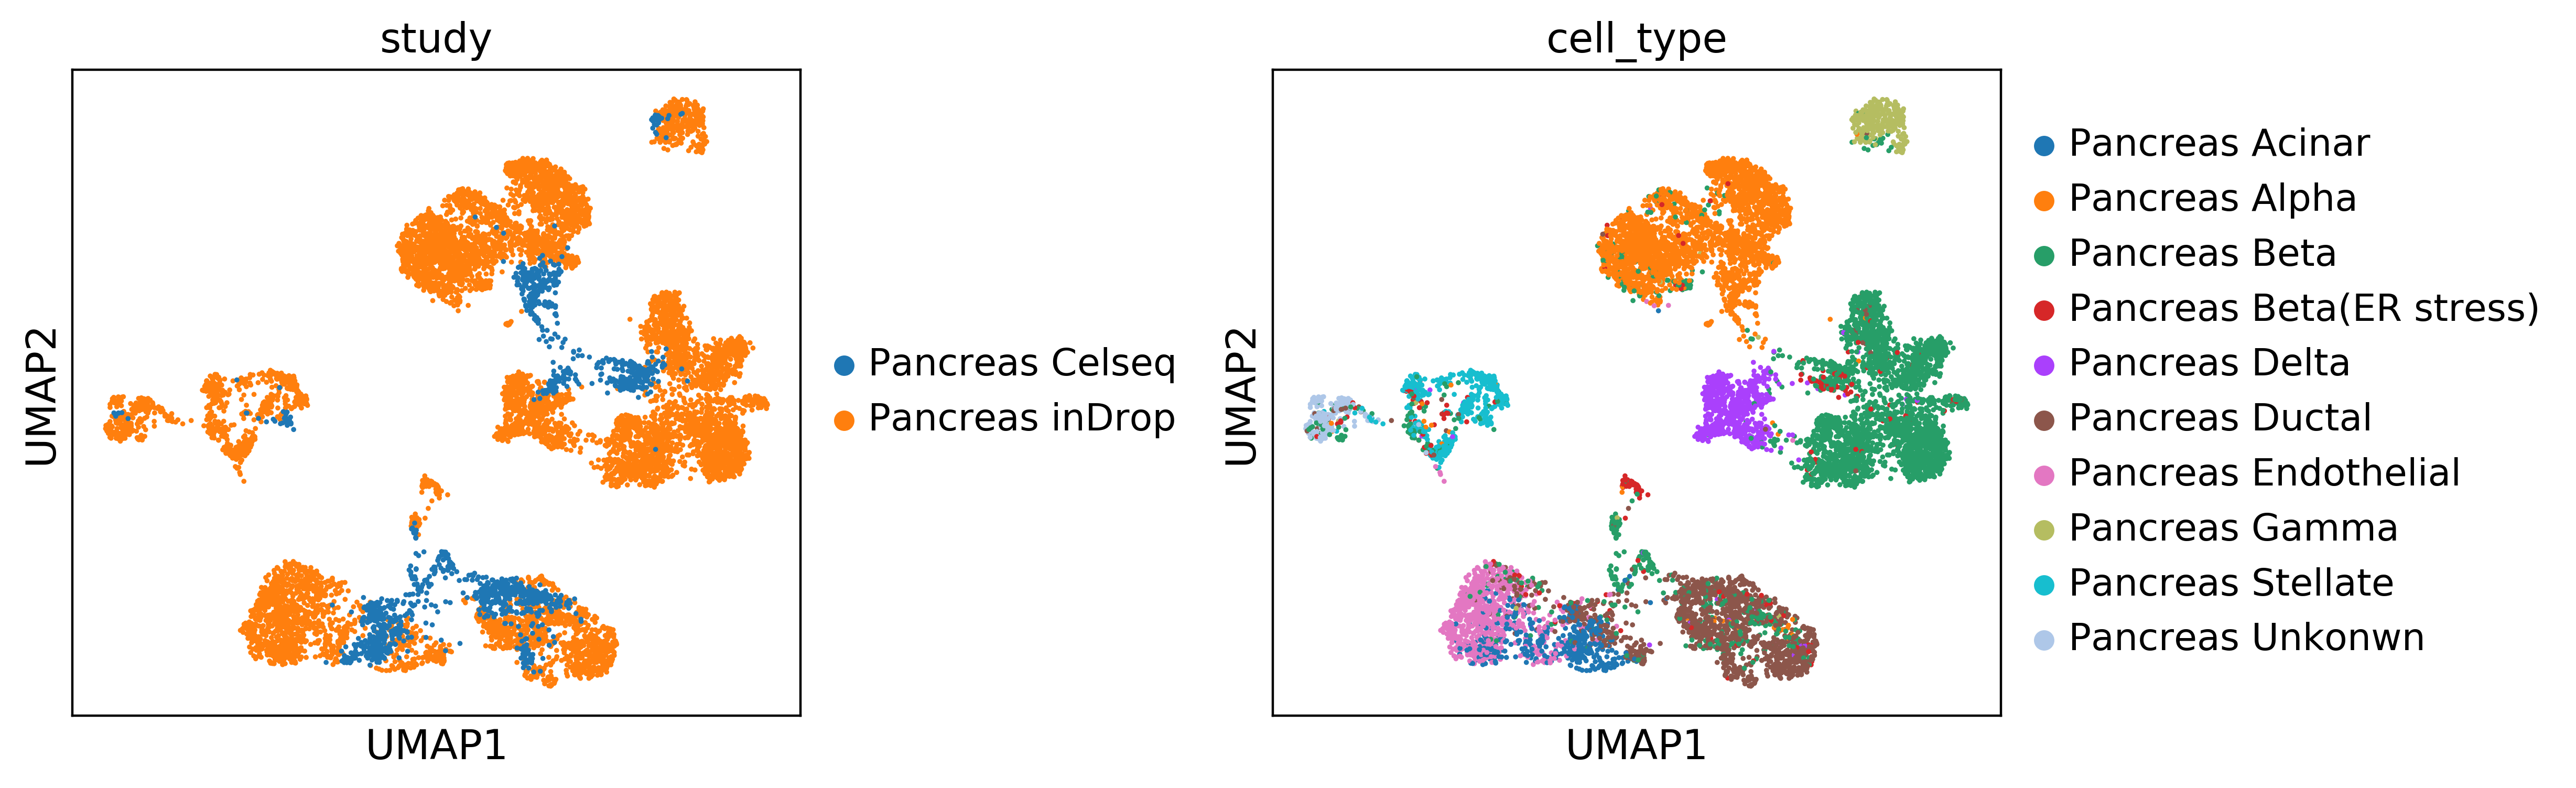

In [21]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)

In [29]:
adata = adata_count[adata_count.obs[condition_key].isin(['Pancreas CelSeq2'])]
adata = adata[:, adata_normalized.var_names]
adata

View of AnnData object with n_obs × n_vars = 2449 × 2000 
    obs: 'batch', 'study', 'cell_type'

In [30]:
adata = sn.tl.normalize(adata,
                             filter_min_counts=False,
                             logtrans_input=True,
                             size_factors=True,
                             normalize_input=False,
                             n_top_genes=-1,
                            )
adata

Trying to set attribute `.obs` of view, making a copy.


AnnData object with n_obs × n_vars = 2449 × 2000 
    obs: 'batch', 'study', 'cell_type', 'n_counts', 'size_factors'

In [33]:
train_adata, valid_adata = sn.tl.train_test_split(adata, 0.80)
train_adata.shape, valid_adata.shape

((1959, 2000), (490, 2000))

In [35]:
new_network = sn.operate(network,
                              new_conditions=['Pancreas CelSeq2'],
                              remove_dropout=False,
                              init='Xavier',
                              freeze=True)

/home/mohsen/scnet/surgeon/models/_cvae.py:159: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  output=h_disp)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 2000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 3)            0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 2003)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
first_layer (Dense)             (None, 128)          256384      concatenate_3[0][0]              
__________

In [36]:
new_network.condition_encoder

{'Pancreas inDrop': 0, 'Pancreas Celseq': 1, 'Pancreas CelSeq2': 2}

In [54]:
new_network.train(train_adata,
                  valid_adata,
                  condition_key=condition_key,
                  cell_type_key=cell_type_key,
                  le=new_network.condition_encoder,
                  n_epochs=500,
                  batch_size=128,
                  early_stop_limit=50,
                  lr_reducer=50,
                  n_per_epoch=0,
                  save=False,
                  retrain=True,
                  verbose=2)

Train on 1959 samples, validate on 490 samples
Epoch 1/500
 - 0s - loss: 0.9934 - nb: 0.9923 - val_loss: 0.9617 - val_nb: 0.9607
Epoch 2/500
 - 0s - loss: 0.9912 - nb: 0.9901 - val_loss: 0.9622 - val_nb: 0.9611
Epoch 3/500
 - 0s - loss: 0.9929 - nb: 0.9918 - val_loss: 0.9617 - val_nb: 0.9606
Epoch 4/500
 - 0s - loss: 0.9907 - nb: 0.9897 - val_loss: 0.9624 - val_nb: 0.9613
Epoch 5/500
 - 0s - loss: 0.9919 - nb: 0.9908 - val_loss: 0.9625 - val_nb: 0.9614
Epoch 6/500
 - 0s - loss: 0.9904 - nb: 0.9894 - val_loss: 0.9623 - val_nb: 0.9612
Epoch 7/500
 - 0s - loss: 0.9928 - nb: 0.9918 - val_loss: 0.9616 - val_nb: 0.9606
Epoch 8/500
 - 0s - loss: 0.9922 - nb: 0.9912 - val_loss: 0.9617 - val_nb: 0.9606
Epoch 9/500
 - 0s - loss: 0.9945 - nb: 0.9935 - val_loss: 0.9620 - val_nb: 0.9609
Epoch 10/500
 - 0s - loss: 0.9923 - nb: 0.9912 - val_loss: 0.9617 - val_nb: 0.9607
Epoch 11/500
 - 0s - loss: 0.9896 - nb: 0.9885 - val_loss: 0.9610 - val_nb: 0.9600
Epoch 12/500
 - 0s - loss: 0.9929 - nb: 0.9918 - 

In [41]:
adata_old = adata_count[adata_count.obs[condition_key].isin(starter_batches)]
adata_old = adata_old[:, adata_normalized.var_names]
adata_old

View of AnnData object with n_obs × n_vars = 9845 × 2000 
    obs: 'batch', 'study', 'cell_type'

In [42]:
adata_old = sn.tl.normalize(adata_old,
                                     filter_min_counts=False,
                                     logtrans_input=True,
                                     size_factors=True,
                                     normalize_input=False,
                                     n_top_genes=-1,
                                    )
adata_old

Trying to set attribute `.obs` of view, making a copy.


AnnData object with n_obs × n_vars = 9845 × 2000 
    obs: 'batch', 'study', 'cell_type', 'n_counts', 'size_factors'

In [45]:
encoder_labels, _ = sn.utils.label_encoder(
    adata_old, label_encoder=network.condition_encoder, condition_key=condition_key)

In [46]:
latent_adata = new_network.to_latent(adata_old, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 9845 × 20 
    obs: 'batch', 'study', 'cell_type', 'n_counts', 'size_factors'

In [47]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

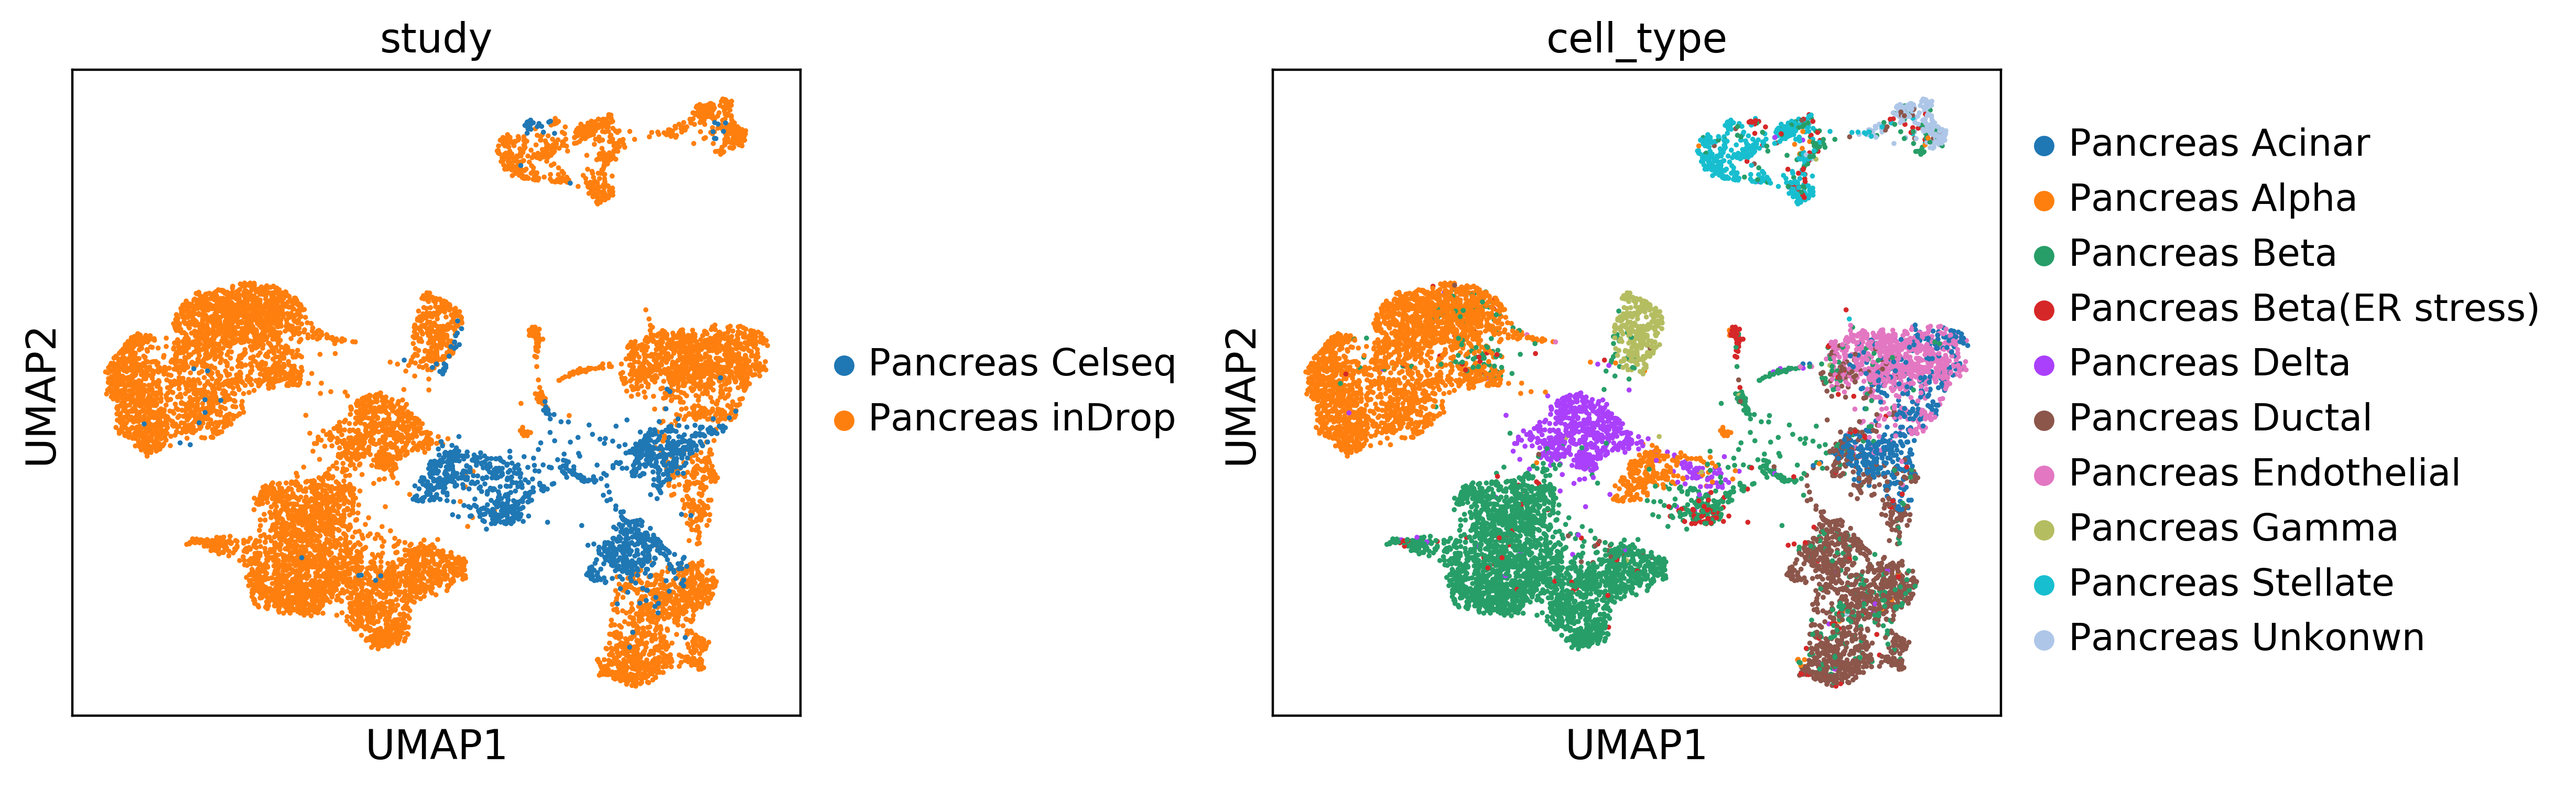

In [48]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)

In [55]:
adata_with_old = adata.concatenate(adata_old)
adata_with_old

AnnData object with n_obs × n_vars = 12294 × 2000 
    obs: 'batch', 'cell_type', 'n_counts', 'size_factors', 'study'

In [56]:
encoder_labels, _ = sn.utils.label_encoder(
    adata_with_old, label_encoder=network.condition_encoder, condition_key=condition_key)

In [57]:
latent_adata = new_network.to_latent(adata_with_old, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 12294 × 20 
    obs: 'batch', 'cell_type', 'n_counts', 'size_factors', 'study'

In [58]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

/home/mohsen/.local/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


... storing 'study' as categorical


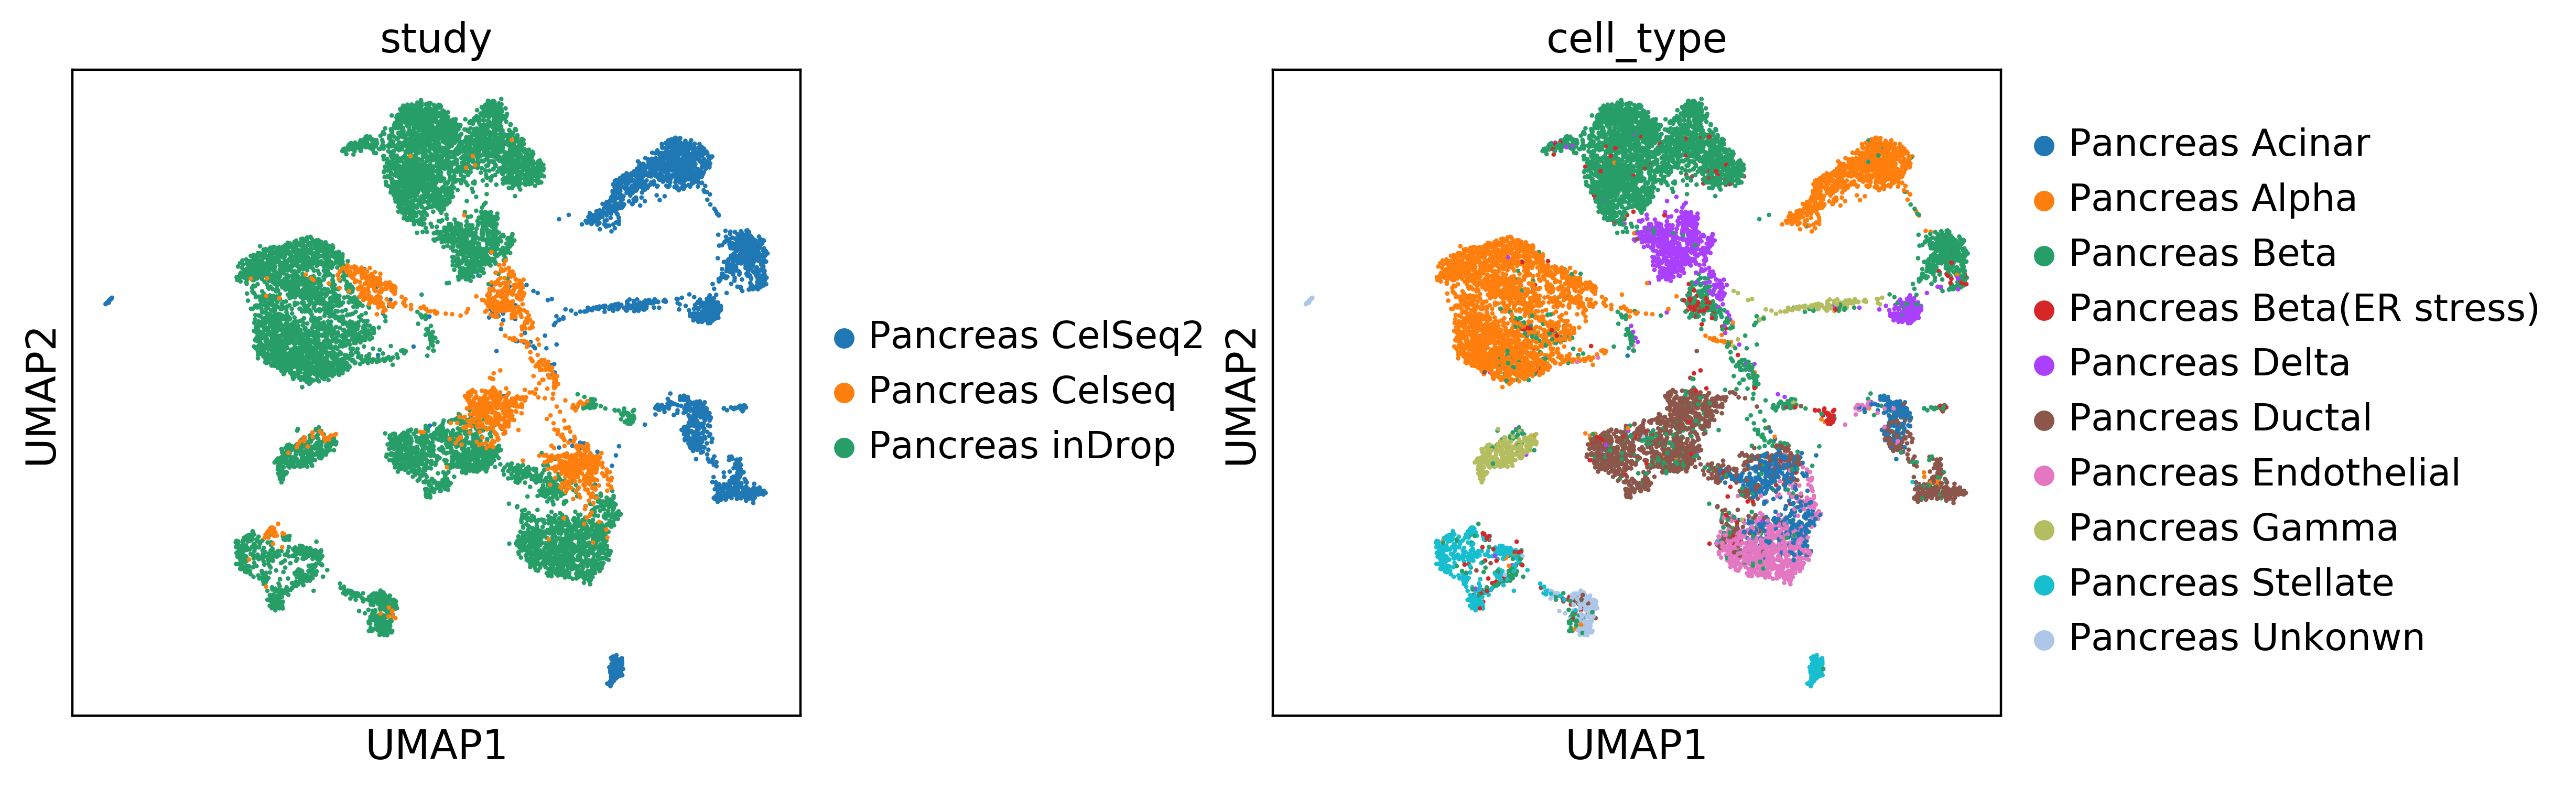

In [59]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)